In [ ]:
from nbdev import *
%nbdev_no_test all

# 42-initial-model
> Generating an initial Spacy model with defaults

In this notebook, we use the modules that we've created in order to assemble an entire pipeline using the `Spatial Historian` xml and entity files to create an NER model in Spacy.

In [ ]:
#default_exp model_performance_utils
#all_flags

In [ ]:
#no_test
#export
#data structure imports
import pandas as pd
import numpy as np

#python imports
import random

#modeling imports
from spacy.util import fix_random_seed
from ssda_nlp.collate import *
#from ssda.entity_corpus import *
#from ssda.xml_parser import *
from ssda_nlp.split_data import *
from ssda_nlp.modeling import *

# Data loading and setup parameters

In [ ]:
#no_test
seed = 2436
random.seed(seed)
fix_random_seed(seed)

In [ ]:
#no_test
# load and create df from xml
xml_df = parse_xml("four.xml")

# Create entity df from entity csvs
ent_df = entity_df_maker("FourPeoplePerEntry.csv", "FourPeople.csv")

# Put these two dfs together and with entity span info
collated_df = collate_frames(xml_df, ent_df)

# Split data
train_df, valid_df, test_df = split_data_grp(collated_df, prop_train = 0.7, prop_validation = 0.2, grp_var = 'entry_no', seed=seed)

# Generate Spacy datasets
train_spacy = genSpaCyInput(train_df)

# Look at column names
train_df.head(10)

C:\Users\bellcs1\Documents\projects\ssda-entity-extraction\ssda\entity_corpus.py:101: UserWarning: You have 52 duplicate rows.  Dropping...
  warnings.warn("You have {} duplicate rows.  Dropping...".format(no_dups))


,vol_id,vol_titl,fol_id,entry_no,text,entity,start,end,label
13,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-2,"N 2 Josef Rafael, Congo Juana Leandra Henrique...",Andres Cascales,239,254,PER
14,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-2,"N 2 Josef Rafael, Congo Juana Leandra Henrique...",Andres Cascales,718,733,PER
15,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-2,"N 2 Josef Rafael, Congo Juana Leandra Henrique...",Francisco Cortinas,663,681,PER
16,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-2,"N 2 Josef Rafael, Congo Juana Leandra Henrique...",Josef Rafael,4,16,PER
17,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-2,"N 2 Josef Rafael, Congo Juana Leandra Henrique...",Josef Rafael,386,398,PER
18,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-2,"N 2 Josef Rafael, Congo Juana Leandra Henrique...",Juana Leandra,24,37,PER
19,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-2,"N 2 Josef Rafael, Congo Juana Leandra Henrique...",Juana Leandra,444,457,PER
20,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-2,"N 2 Josef Rafael, Congo Juana Leandra Henrique...",Juan de Dios Henrique,507,528,PER
21,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-2,"N 2 Josef Rafael, Congo Juana Leandra Henrique...",Maria del Rosario de Hita,534,559,PER
22,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-2,"N 2 Josef Rafael, Congo Juana Leandra Henrique...",Pedro Ruiz,685,695,PER


## Basic verification of split behavior

Let just quickly look at the data sizes so we can see what we have to work with:

In [ ]:
print('Train size: {0}'.format(len(train_df)))
print('Valid size: {0}'.format(len(valid_df)))
print('Test size: {0}'.format(len(test_df)))

Train size: 334
Valid size: 102
Test size: 49


This basically informs the limits of our batch sizes.  The train size is basically 330, which means we need to probably watch the compounding.  Let's also just quickly look at the entities that we've split into:

In [ ]:
train_df.groupby(['vol_id', 'entry_no'])['entity'].aggregate(lambda x: list(x)).head(10)

vol_id  entry_no
1710    1711-2      [Andres Cascales, Andres Cascales, Francisco C...
        1714-1      [Andres Cascales, Andres Cascales, Francisco C...
        1715-1      [Andres Cascales, Andres Cascales, Francisco C...
        1715-2      [Andres Cascales, Maria Merced, Maria Merced, ...
        1716-1      [Andres Cascales, Andres Cascales, Rafael Mora...
        1717-1      [Andres Cascales, Andres Cascales, Juan Escoba...
        1717-2      [Andres Cascales, Francisco Maria Lucumi, Fran...
        1718-1      [Andres Cascales, Andres Cascales, Juan Escoba...
        1718-2      [Andres Cascales, Andres Cascales, Josef Rafae...
        1719-1      [Andres Cascales, Andres Cascales, Josef Rafae...
Name: entity, dtype: object

In [ ]:
valid_df.groupby(['vol_id', 'entry_no'])['entity'].aggregate(lambda x: list(x)).head(10)

vol_id  entry_no
1710    1711-1      [Andres Cascales, Andres Cascales, Maria del C...
        1714-2      [Andres Cascales, Andres Cascales, Francisco C...
        1716-2      [Andres Cascales, Andres Cascales, Rafael Mora...
        1722-1      [Andres Cascales, Manuel Valdes, Clemente Bric...
        1723-1      [Andres Cascales, Andres Cascales, Manuel Vald...
        1723-2      [Andres Cascales, Manuel Valdes, Marcelino Con...
        1725-1      [Andres Cascales, Andres Cascales, Pedro Villa...
        1726-2      [Andres Cascales, Andres Cascales, Mariano Val...
        1742-1      [Andres Cascales, Pedro Garcia, Felix Jose Des...
        1749-1      [Andres Cascales, Andres Cascales, Manuel Vald...
Name: entity, dtype: object

There don't appear to be any overlapping groups between train and valid.  Let's just take a quick look at the actual Spacy format to make sure things are looking good.

In [ ]:
train_spacy[:2]

[('N 2 Josef Rafael, Congo Juana Leandra Henrique En la ciudad de la Havana, en tres de Agosto de milochocien tos y doze años, haviendose leydo las tres canonicas amonestaciones en tres días festivos sin resultar impedimento, yo Licenciado D Andres Cascales Beneficiado por S Majestad de la Iglesia Auxiliar, del Santo Angel Custodio de esta ciudad de la Havana, casé y velé #itualmente á Josef Rafael, Congo, esclavo de D Juan Josef de Hita, y á Juana Leandra, morena criolla de esta ciudad, hija legítima de Juan de Dios Henrique y de Maria del Rosario de Hita, y dhos contrayentes confesa# y comulgaron, fueron examinados en la doctrina Cristiana sie# testigos D Francisco Cortinas, y Pedro Ruiz y lo firme Licenciado Andres Cascales ',
  {'entities': [(239, 254, 'PER'),
    (718, 733, 'PER'),
    (663, 681, 'PER'),
    (4, 16, 'PER'),
    (386, 398, 'PER'),
    (24, 37, 'PER'),
    (444, 457, 'PER'),
    (507, 528, 'PER'),
    (534, 559, 'PER'),
    (685, 695, 'PER'),
    (420, 438, 'PER')]}

Here, we train a new model based on the generated training inputs.

# Model training and validation
In this section, we're going to merge the concepts of training and validation.  We're basically going to measure the performance of the model after every `n` iterations using the validation set.  We'll save any models which beat the previous perfromance, basically overwriting the previous one.  If the performance according to some metric doesn't improve, then we don't save that particular version, and we just abort training.  We'll save all of the training/validation results.

In [ ]:
#boolean indicating whether to keep training
keep_training = True
eval_metric = 'f_score'

#spacy parameters
cping = {'start':16, 'end':32, 'cp_rate':1.05}
solves = {'learn_rate':0.0003}
dpout = 0.4

#other settings
no_its = 10
save_dir = 'models/42-initial-model/4e0f496_dp{0}_lr{1}_sd{2}'.format(dpout, solves['learn_rate'], seed)
old_metric_val = -1
cycle_no = 1
patience_max = 5
patience = patience_max

#output datafarme
df_cols = ['cycle_no', 'avg_cycle_loss', 'precision', 'recall', 'f_score']
perf_df = pd.DataFrame(columns = df_cols)

#load model from pretrained
nlp_model = load_model('es_core_news_sm')

while keep_training is True:
    
    # Train for the number of desired iterations
    nlp_model, loss_df = train_model(nlp_model, train_spacy, n_iter = no_its, dropout = dpout, compound_params = cping, solver_params=solves)
    
    # Test based on the validation set to get performance and log
    ent_preds_df, metrics_df, per_ent_metrics = test_model(nlp_model, valid_df, 'entry_no', 'text')
    cycle_df_0 = pd.DataFrame(np.array([[cycle_no, loss_df['epoch_loss'].mean()]]), columns=df_cols[:2])
    cycle_df = pd.concat([cycle_df_0, metrics_df], axis=1)
    display(cycle_df)
    perf_df = pd.concat([perf_df, cycle_df])
    
    # If the performance is *strictly* better than previous performance (sometimes the performance is the same), save the model and performance
    if metrics_df.loc[0, eval_metric] > old_metric_val:
        old_metric_val = metrics_df.loc[0, eval_metric]
        save_model(nlp_model, save_dir)
        cycle_no += 1
        patience = patience_max
    else:
        # If the performance isn't better after patience cycles, abort
        patience -= 1
        print("Performance hasn't improved for {0} cycles...".format(patience_max - patience))
        cycle_no += 1
        if patience==0:
            keep_training=False
            
            #Save performance
            perf_df.reset_index(drop=True, inplace=True)
            perf_df.to_csv(save_dir + '/perf_df.csv', index=False)
            print('Done training after {0} meta cycles.'.format(cycle_no-1))

,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,993.087368,59.615385,60.784314,60.194175


Saved model to models\42-initial-model\4e0f496_dp0.4_lr0.0003_sd2436


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,614.796204,64.46281,76.470588,69.955157


Saved model to models\42-initial-model\4e0f496_dp0.4_lr0.0003_sd2436


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,482.256014,71.666667,84.313725,77.477477


Saved model to models\42-initial-model\4e0f496_dp0.4_lr0.0003_sd2436


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,403.439256,73.170732,88.235294,80.0


Saved model to models\42-initial-model\4e0f496_dp0.4_lr0.0003_sd2436


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,352.871608,73.770492,88.235294,80.357143


Saved model to models\42-initial-model\4e0f496_dp0.4_lr0.0003_sd2436


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,308.888319,71.653543,89.215686,79.475983


Performance hasn't improved for 1 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,293.331318,72.8,89.215686,80.176211


Performance hasn't improved for 2 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,279.13852,72.222222,89.215686,79.824561


Performance hasn't improved for 3 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,267.719926,73.387097,89.215686,80.530973


Saved model to models\42-initial-model\4e0f496_dp0.4_lr0.0003_sd2436


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,246.450531,73.170732,88.235294,80.0


Performance hasn't improved for 1 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,231.378209,71.653543,89.215686,79.475983


Performance hasn't improved for 2 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,210.209835,71.653543,89.215686,79.475983


Performance hasn't improved for 3 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,202.22921,74.380165,88.235294,80.717489


Saved model to models\42-initial-model\4e0f496_dp0.4_lr0.0003_sd2436


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,192.204546,74.796748,90.196078,81.777778


Saved model to models\42-initial-model\4e0f496_dp0.4_lr0.0003_sd2436


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,15.0,180.864256,74.193548,90.196078,81.415929


Performance hasn't improved for 1 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,16.0,174.761797,77.310924,90.196078,83.257919


Saved model to models\42-initial-model\4e0f496_dp0.4_lr0.0003_sd2436


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,17.0,168.214851,75.409836,90.196078,82.142857


Performance hasn't improved for 1 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,18.0,156.17667,77.310924,90.196078,83.257919


Performance hasn't improved for 2 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,19.0,152.096046,74.796748,90.196078,81.777778


Performance hasn't improved for 3 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,20.0,150.359625,79.310345,90.196078,84.40367


Saved model to models\42-initial-model\4e0f496_dp0.4_lr0.0003_sd2436


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,21.0,138.754392,77.777778,89.215686,83.105023


Performance hasn't improved for 1 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,22.0,129.865512,74.796748,90.196078,81.777778


Performance hasn't improved for 2 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,23.0,133.349983,74.166667,87.254902,80.18018


Performance hasn't improved for 3 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,24.0,125.457596,75.423729,87.254902,80.909091


Performance hasn't improved for 4 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,25.0,124.406456,76.068376,87.254902,81.278539


Performance hasn't improved for 5 cycles...
Done training after 25 meta cycles.


### Model training utility
As a brief aside, I'm going to add a function here which implements this stopping loop in case anyone else would like to use it.

In [ ]:
#export
def model_meta_training(mdl, train_spacy, valid_df, eval_metric = 'f_score', patience_max = 5, save_dir = None, verbose=False, **kwargs):
    '''
    Function model_meta_training: a model wrapping function which implements early stopping based on model improvement on the validation set.
        Inputs: mdl: Spacy model, blank or pretrained
                train_spacy: training data in Spacy format
                valid_df: dataframe of validation data split
                eval_metric: metric on which the validation performance should be evaluated.  Can be `f_score`, `precision` or `recall`.
                patience_max (default 5): Number of iterations to wait for the model performance to improve
                save_dir (default None): String of data directory.  Use this parameter if you want the best model and its performance to be saved to disk.
                verbose (default False): Boolean indicating whether you want to print the performance after every *iterations* iterations.
                **kwargs: keyword arguments which will be passed directly to `train_model`.  You should include at least the parameter n_iter and set it low
                    to something like 10.
        Returns: mdl: Spacy model, although the original variable you passed in will still be a valid reference.  NOTE THAT THIS MODEL WILL BE OVERTRAINED BY
                      PATIENCE CYCLES.  If you want the "best" model back, you'll need to load it from the saved directory.
                 perf_df: pandas dataframe with the training performance (avg_cycle_loss) and validation performance (precision, recall, f_score) at every
                      n_iter iterations, including the patience cycles.
    '''
    
    #loop parameters
    keep_training = True
    old_metric_val = -1
    cycle_no = 1
    patience = patience_max
    
    #output datafarme
    df_cols = ['cycle_no', 'avg_cycle_loss', 'precision', 'recall', 'f_score']
    perf_df = pd.DataFrame(columns = df_cols)
    
    #training loop
    while keep_training is True:
    
        # Train for the number of desired iterations
        mdl, loss_df = train_model(mdl, train_spacy, **kwargs)

        # Test based on the validation set to get performance and log
        ent_preds_df, metrics_df, per_ent_metrics = test_model(mdl, valid_df, 'entry_no', 'text')
        cycle_df_0 = pd.DataFrame(np.array([[cycle_no, loss_df['epoch_loss'].mean()]]), columns=df_cols[:2])
        cycle_df = pd.concat([cycle_df_0, metrics_df], axis=1)
        perf_df = pd.concat([perf_df, cycle_df])
        
        #print if desired
        if verbose: display(cycle_df)

        # If the performance is *strictly* better than previous performance (sometimes the performance is the same), save the model and performance
        if metrics_df.loc[0, eval_metric] > old_metric_val:
            old_metric_val = metrics_df.loc[0, eval_metric]
            if save_dir is not None:
                save_model(mdl, save_dir)
            
            #modify looping parameters
            cycle_no += 1
            patience = patience_max
        else:
            # If the performance isn't better, wait patience cycles
            patience -= 1
            if verbose: print("Performance hasn't improved for {0} cycles...".format(patience_max - patience))
            cycle_no += 1
            
            #If you've exhausted the patience, end training
            if patience==0:
                
                #Stop training loop
                keep_training=False

                #Save performance
                perf_df.reset_index(drop=True, inplace=True)
                if save_dir is not None:
                    perf_df.to_csv(save_dir + '/perf_df.csv', index=False)
                if verbose:
                    print('Done training after {0} meta cycles.'.format(cycle_no-1))
    
    return mdl, perf_df

Here's an example of how you would use this:

In [ ]:
#if you want the same model everytime:
random.seed(seed)
fix_random_seed(seed)

#spacy parameters
cping = {'start':16, 'end':32, 'cp_rate':1.05}
solves = {'learn_rate':0.0003}
dpout = 0.4
save_mdir = 'models/test'

#load model from pretrained
nlp_model = load_model('es_core_news_sm')

nlp_model, perf_df = model_meta_training(nlp_model, train_spacy, valid_df, verbose=True, save_dir = save_mdir,
                                         n_iter=10, solver_params=solves, compound_params=cping, dropout=dpout)

,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,767.404284,55.769231,58.585859,57.142857


Saved model to models\test


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,492.495607,59.349593,73.737374,65.765766


Saved model to models\test


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,393.995564,63.865546,76.767677,69.724771


Saved model to models\test


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,321.43365,67.521368,79.79798,73.148148


Saved model to models\test


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,296.67752,69.354839,86.868687,77.130045


Saved model to models\test


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,263.913321,69.918699,86.868687,77.477477


Saved model to models\test


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,239.27558,69.672131,85.858586,76.923077


Performance hasn't improved for 1 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,222.961693,68.0,85.858586,75.892857


Performance hasn't improved for 2 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,208.465027,69.747899,83.838384,76.146789


Performance hasn't improved for 3 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,199.173228,69.166667,83.838384,75.799087


Performance hasn't improved for 4 cycles...


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,193.503135,70.0,84.848485,76.712329


Performance hasn't improved for 5 cycles...
Done training after 11 meta cycles.


After this, you'll have the entire `perf_df` for a single run.  If you want to evalute the performance of the best model, you'll need to load it from file and then run `test_model` using the training or validation df of interest.  Note that when you set the seed above, you'll get the same train/test/valid split if you use the same seed.

This function makes it straightforward to iterate over multiple values for dropout, compounding, or other parameters.

# Performance Investigation
In looking at the performance of the model, both the sensitivity (recall) and precision (positive predictive value) are both pretty good!

The performance of a model is usually measured through metrics, but you also have to think about how you'll use the model in practice. Here, I'll look a little deeper into the performance on the validation set to see where we might improve.

## Training curves
Let's first look at the training vs validation performance curves.

In [ ]:
#load saved model and performance metrics if desired:
#this_model_dir = 'models/42-initial-model/4e0f496_dp0.4_lr0.0003'
#nlp_model = load_model(this_model_dir)
#perf_df = read_csv(this_model_dir + '\perf_df.csv')

In [ ]:
perf_df.set_index('cycle_no', drop=True, inplace=True)
perf_df.head()

,avg_cycle_loss,precision,recall,f_score
cycle_no,,,,
1.0,993.087368,59.615385,60.784314,60.194175
2.0,614.796204,64.462810,76.470588,69.955157
3.0,482.256014,71.666667,84.313725,77.477477
4.0,403.439256,73.170732,88.235294,80.000000
5.0,352.871608,73.770492,88.235294,80.357143


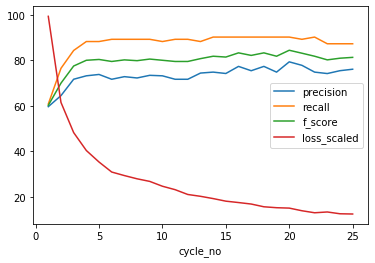

In [ ]:
#scale the losses a bit just to see things together
perf_df['loss_scaled'] = perf_df['avg_cycle_loss']/10
perf_df.drop(columns=['avg_cycle_loss']).plot()

## Entity performance
To look at this, we're going to join the results of the identified entity dataframe as an outer join, on the `entity`, `start`, and `end` information.  Thus, any row in the resulting table that has NAs in the `valid_df` side was not correctly identified (e.g., wrong span), and any row that has NAs in the `ent_preds_df` side wasn't correctly identified (false negative).  Let's check out what's going on.

In [ ]:
print('Total enumeration of predicted entities: ', ent_preds_df.shape[0], 'of ', valid_df.shape[0], 'possible entities.')
ent_preds_df.head(50)

Total enumeration of predicted entities:  117 of  102 possible entities.


,entry_no,pred_entity,pred_label,pred_start,pred_end
0,1711-1,Pablo Ayende Maria Josefa,PER,9,34
1,1711-1,Andres Cascales,PER,238,253
2,1711-1,Pablo,PER,385,390
3,1711-1,Josef Antonio,PER,439,452
4,1711-1,Maria de la Soledad Olibos,PER,458,484
5,1711-1,Maria del Carmen Fernandez,PER,495,521
6,1711-1,Juan Bautista,PER,597,610
7,1711-1,Felipa Carvajal,PER,617,632
8,1711-1,Eugenio Gomes,PER,759,772
9,1711-1,Maria del Rosa # #,PER,776,794


Let's look at the joined results:

In [ ]:
join_df = pd.merge(valid_df, ent_preds_df, left_on=['entry_no', 'entity', 'start', 'end'],
                   right_on =['entry_no', 'pred_entity', 'pred_start', 'pred_end'], how='outer')
print('Fully joined results size: ', len(join_df))
join_df.head(20)

Fully joined results size:  131


,vol_id,vol_titl,fol_id,entry_no,text,entity,start,end,label,pred_entity,pred_label,pred_start,pred_end
0,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Andres Cascales,238.0,253.0,PER,Andres Cascales,PER,238.0,253.0
1,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Andres Cascales,891.0,906.0,PER,Andres Cascales,PER,891.0,906.0
2,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Maria del Carmen Fernandez,495.0,521.0,PER,Maria del Carmen Fernandez,PER,495.0,521.0
3,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Pablo Ayende,9.0,21.0,PER,NaN,NaN,NaN,NaN
4,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Pablo Ayende,385.0,397.0,PER,NaN,NaN,NaN,NaN
5,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Maria Josefa Catarina Gomes,527.0,554.0,PER,NaN,NaN,NaN,NaN
6,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Josef Antonio,439.0,452.0,PER,Josef Antonio,PER,439.0,452.0
7,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Maria de la Soledad Olibos,458.0,484.0,PER,Maria de la Soledad Olibos,PER,458.0,484.0
8,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Francisco Cortinas,809.0,827.0,PER,Francisco Cortinas,PER,809.0,827.0
9,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Juan Bautista,597.0,610.0,PER,Juan Bautista,PER,597.0,610.0


In [ ]:
join_df.groupby(['vol_id', 'entry_no'])[['text', 'entity', 'pred_entity']].aggregate(lambda x: list(x))

text  \
vol_id entry_no                                                      
1710   1711-1    [Número 1 Pablo Ayende Maria Josefa Gomés En l...   
       1714-2    [N 4 #mas Mariano #zales Mandinga Maria Luisa ...   
       1716-2    [N 8 Marcelino Joaquin Bricamo, y Tomasa Criol...   
       1722-1    [6.  Año de 1813  N 21 Clemente Bricamo, y Mar...   
       1723-1    [N 23 Vicente, Arara y Antonia Maria Mandinga....   
       1723-2    [N 24 Marcelino Congo, y Maria Moncerrate En l...   
       1725-1    [N 27 Jacinto Ganga, y Manuela Mandinga En la ...   
       1726-2    [N 30 Josef Dolores Amador, Micaela Albarados ...   
       1742-1    [N. 41. Felix Jose Desiderio Chapuz y Maria de...   
       1749-1    [N. 51. Jose Villafranca, y Rosa Maria Macua E...   

                                                            entity  \
vol_id entry_no                                                      
1710   1711-1    [Andres Cascales, Andres Cascales, Maria del C...   
       1714-2    [Andres Cascales, Andres Cascales, Francisco C...   
       1716-2    [Andres Cascales, Andres Cascales, Rafael Mora...   
       1722-1    [Andres Cascales, Manuel Valdes, Clemente Bric...   
       1723-1    [Andres Cascales, Andres Cascales, Manuel Vald...   
       1723-2    [Andres Cascales, Manuel Valdes, Marcelino Con...   
       1725-1    [Andres Cascales, Andres Cascales, Pedro Villa...   
       1726-2    [Andres Cascales, Andres Cascales, Mariano Val...   
       1742-1    [Andres Cascales, Pedro Garcia, Felix Jose Des...   
       1749-1    [Andres Cascales, Andres Cascales, Manuel Vald...   

                                                       pred_entity  
vol_id entry_no                                                     
1710   1711-1    [Andres Cascales, Andres Cascales, Maria del C...  
       1714-2    [Andres Cascales, Andres Cascales, Francisco C...  
       1716-2    [Andres Cascales, Andres Cascales, nan, Tomasa...  
       1722-1    [Andres Cascales, Manuel Valdes, Clemente Bric...  
       1723-1    [Andres Cascales, Andres Cascales, Manuel Vald...  
       1723-2    [Andres Cascales, Manuel Valdes, Marcelino Con...  
       1725-1    [Andres Cascales, Andres Cascales, Pedro Villa...  
       1726-2    [Andres Cascales, Andres Cascales, Mariano Val...  
       1742-1    [Andres Cascales, Pedro Garcia, Felix Jose Des...  
       1749-1    [Andres Cascales, Andres Cascales, Manuel Vald...

### Correctly labeled entities
Now, let's separate the dataframes into correct vs incorrect.  We do this on the basis of NAs.  We'll separate the wrongly identified dfs into how they're wrong: false_negatives (NAs on the preds side), or false_positive (NAs on the entity side).

In [ ]:
corrects_df = join_df.dropna().sort_values(['vol_id', 'entry_no'])
print("Number correctly identified: ", corrects_df.shape[0], " of ", valid_df.shape[0])
corrects_df.head(20)

Number correctly identified:  88  of  102


,vol_id,vol_titl,fol_id,entry_no,text,entity,start,end,label,pred_entity,pred_label,pred_start,pred_end
0,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Andres Cascales,238.0,253.0,PER,Andres Cascales,PER,238.0,253.0
1,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Andres Cascales,891.0,906.0,PER,Andres Cascales,PER,891.0,906.0
2,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Maria del Carmen Fernandez,495.0,521.0,PER,Maria del Carmen Fernandez,PER,495.0,521.0
6,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Josef Antonio,439.0,452.0,PER,Josef Antonio,PER,439.0,452.0
7,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Maria de la Soledad Olibos,458.0,484.0,PER,Maria de la Soledad Olibos,PER,458.0,484.0
8,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Francisco Cortinas,809.0,827.0,PER,Francisco Cortinas,PER,809.0,827.0
9,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Juan Bautista,597.0,610.0,PER,Juan Bautista,PER,597.0,610.0
10,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Felipa Carvajal,617.0,632.0,PER,Felipa Carvajal,PER,617.0,632.0
11,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Gabriel Garcia,833.0,847.0,PER,Gabriel Garcia,PER,833.0,847.0
12,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Eugenio Gomes,759.0,772.0,PER,Eugenio Gomes,PER,759.0,772.0


### False negative dataframe

In [ ]:
#get predictions that were missed
fn_df = join_df[join_df[['pred_entity', 'pred_start', 'pred_end']].isna().any(axis=1)]

#cleanup for easy viewing
fn_df = fn_df.copy().drop(['vol_titl', 'fol_id', 'pred_entity', 'pred_label', 'pred_start', 'pred_end'], axis=1)
fn_df.sort_values(['vol_id','entry_no'], inplace=True)
print("Number not identified: ", fn_df.shape[0], " of ", valid_df.shape[0])
print('Preview of entities that were not identified in the texts:')
display(fn_df.head(20))

Number not identified:  14  of  102
Preview of entities that were not identified in the texts:


,vol_id,entry_no,text,entity,start,end,label
3,1710,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Pablo Ayende,9.0,21.0,PER
4,1710,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Pablo Ayende,385.0,397.0,PER
5,1710,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Maria Josefa Catarina Gomes,527.0,554.0,PER
17,1710,1714-2,N 4 #mas Mariano #zales Mandinga Maria Luisa C...,Maria Luisa Cabral,33.0,51.0,PER
20,1710,1714-2,N 4 #mas Mariano #zales Mandinga Maria Luisa C...,Raf# #ales,709.0,719.0,PER
25,1710,1716-2,"N 8 Marcelino Joaquin Bricamo, y Tomasa Crioll...",Rafael Morales,690.0,704.0,PER
27,1710,1716-2,"N 8 Marcelino Joaquin Bricamo, y Tomasa Crioll...",Tomasa,428.0,434.0,PER
30,1710,1716-2,"N 8 Marcelino Joaquin Bricamo, y Tomasa Crioll...",Marcelino Joaquin,4.0,21.0,PER
38,1710,1722-1,"6. Año de 1813 N 21 Clemente Bricamo, y Mari...",Maria Josefa Carabali,42.0,63.0,PER
52,1710,1723-1,"N 23 Vicente, Arara y Antonia Maria Mandinga. ...",#erquez,384.0,391.0,PER


In just quickly looking, I think there may be an error in this dataframe.  The name `Tomasa` is supposed to be an entity, but in simply looking at the text, it looks like there's a name `Tomasa Crioll...` which may be the correct entity.  We can look further into this to see if this is incorrectly entered into the ground truth data.

### False positive dataframe

In [ ]:
#pd.set_options('display.max_colwidth', None)

In [ ]:
#get incorrect identifications of entities in the texts
fp_df = join_df[join_df[['entity', 'start', 'end']].isna().any(axis=1)]

#cleanup for easy viewing
fp_df = fp_df.copy().drop(['vol_id', 'vol_titl', 'fol_id', 'entity', 'label', 'start', 'end'], axis=1)

#insert texts and vol_id in the dataframe
fp_df = pd.merge(fp_df, valid_df[['vol_id','entry_no', 'text']], on='entry_no').drop(['text_x'], axis=1)
fp_df.rename(columns={'text_y':'text'}, inplace=True)

#reorder columns
col_order = ['vol_id', 'entry_no', 'text'] + list(fp_df.columns.drop(['vol_id', 'entry_no', 'text']))
fp_df = fp_df[col_order]
fp_df.sort_values(['vol_id','entry_no'], inplace=True)

#I get duplicates because NaNs
fp_df.drop_duplicates(inplace=True)

#print info
print('False positive entities that were not correctly identified in the texts:')
print("Number not correctly identified: ", fp_df.shape[0], " of ", valid_df.shape[0])
fp_df

False positive entities that were not correctly identified in the texts:
Number not correctly identified:  29  of  102


,vol_id,entry_no,text,pred_entity,pred_label,pred_start,pred_end
0,1710,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Pablo Ayende Maria Josefa,PER,9.0,34.0
13,1710,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Pablo,PER,385.0,390.0
26,1710,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Maria del Rosa # #,PER,776.0,794.0
39,1710,1714-2,N 4 #mas Mariano #zales Mandinga Maria Luisa C...,Mariano #,PER,9.0,18.0
49,1710,1714-2,N 4 #mas Mariano #zales Mandinga Maria Luisa C...,Mandinga Maria Luisa Cabral,PER,24.0,51.0
59,1710,1714-2,N 4 #mas Mariano #zales Mandinga Maria Luisa C...,Raf# #,PER,709.0,715.0
69,1710,1716-2,"N 8 Marcelino Joaquin Bricamo, y Tomasa Crioll...",Marcelino Joaquin Bricamo,PER,4.0,29.0
81,1710,1716-2,"N 8 Marcelino Joaquin Bricamo, y Tomasa Crioll...",Tomasa Maria,PER,428.0,440.0
93,1710,1716-2,"N 8 Marcelino Joaquin Bricamo, y Tomasa Crioll...",Armas,PER,665.0,670.0
105,1710,1716-2,"N 8 Marcelino Joaquin Bricamo, y Tomasa Crioll...",Josef Rafael Morales,PER,684.0,704.0


### Span failures

Let's take a look and see if there are any entities that failed only in the span definition.

In [ ]:
span_df = pd.merge(valid_df, ent_preds_df, left_on=['entry_no', 'entity'],
                   right_on =['entry_no', 'pred_entity'], how='inner')
wrong_span_df = span_df.query('start != pred_start or end !=pred_end')
print("Number of potential wrong span definitions: ", wrong_span_df.shape[0])
wrong_span_df.head(30)

Number of potential wrong span definitions:  28


,vol_id,vol_titl,fol_id,entry_no,text,entity,start,end,label,pred_entity,pred_label,pred_start,pred_end
1,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Andres Cascales,238,253,PER,Andres Cascales,PER,891,906
2,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1711,1711-1,Número 1 Pablo Ayende Maria Josefa Gomés En la...,Andres Cascales,891,906,PER,Andres Cascales,PER,238,253
13,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1714,1714-2,N 4 #mas Mariano #zales Mandinga Maria Luisa C...,Andres Cascales,253,268,PER,Andres Cascales,PER,811,826
14,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1714,1714-2,N 4 #mas Mariano #zales Mandinga Maria Luisa C...,Andres Cascales,811,826,PER,Andres Cascales,PER,253,268
18,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1714,1714-2,N 4 #mas Mariano #zales Mandinga Maria Luisa C...,Maria Luisa Cabral,33,51,PER,Maria Luisa Cabral,PER,478,496
24,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1716,1716-2,"N 8 Marcelino Joaquin Bricamo, y Tomasa Crioll...",Andres Cascales,250,265,PER,Andres Cascales,PER,744,759
25,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1716,1716-2,"N 8 Marcelino Joaquin Bricamo, y Tomasa Crioll...",Andres Cascales,744,759,PER,Andres Cascales,PER,250,265
28,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1716,1716-2,"N 8 Marcelino Joaquin Bricamo, y Tomasa Crioll...",Tomasa,428,434,PER,Tomasa,PER,33,39
31,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1716,1716-2,"N 8 Marcelino Joaquin Bricamo, y Tomasa Crioll...",Marcelino Joaquin,4,21,PER,Marcelino Joaquin,PER,382,399
39,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1722,1722-1,"6. Año de 1813 N 21 Clemente Bricamo, y Mari...",Maria Josefa Carabali,42,63,PER,Maria Josefa Carabali,PER,462,483


This dataframe should be interpreted as follows: there are actually no people found in this dataframes whose spans are misidentified (e.g., a space at the end or something).  All the people here are present due to the way that the merge is performed (i.e., it doesn't take into account the spans, so for each instance found of a match, it replicates for each match).

# Functions for performance evaluation
Here, I'll just functionalize some of the code I've written above just for general use if they are of interest.

In [ ]:
#export
def get_ner_df(split_df, ent_df, verbose=True):
    '''
    Function get_ner_df: create joined dataframe of the ground truth dataframe and the prediction dataframe (from Spacy)
        Inputs: split_df: dataframe of split data (e.g., train, test, or validation)
                ent_df: dataframe of entities predicted from the data (e.g., from ssda.modeling: test_model)
                verbose (default True): True if you want to print shape information about the dataframes created.
        Returns: dataframe of fully joined results (an outer join so all rows are reported, regardless of whether they have matches)    
    '''
    
    #join original dataframe df with entities recognized df
    ner_df = pd.merge(split_df, ent_df, left_on=['entry_no', 'entity', 'start', 'end'],
                   right_on =['entry_no', 'pred_entity', 'pred_start', 'pred_end'], how='outer')
    
    #print if verbose
    if verbose: print('Fully joined results size: ', len(ner_df))
    
    return ner_df

In [ ]:
#export
def get_corrects_df(ner_df, split_df, verbose=True):
    '''
    Function get_corrects_df: get dataframe of entities which were correctly identified
        Inputs: ner_df: fully joined dataframe of entity ground truth and prediction results (e.g., from `get_ner_df`)
                split_df: dataframe of split data (e.g., train, test, or validation)
                verbose (default True): True if you want to print shape information about the dataframes created.
        Returns: dataframe of correctly identified entities with metadata
    '''
    corrs_df = ner_df.dropna().sort_values(['vol_id', 'entry_no'])
    if verbose: print("Number correctly identified: ", corrs_df.shape[0], " of ", split_df.shape[0])
    
    return corrs_df

In [ ]:
#export
def get_fns_df(ner_df, split_df, verbose=True):
    '''
    Function get_fns_df: get dataframe of ground truth entities which were not predicted by the model
        Inputs: ner_df: fully joined dataframe of entity ground truth and prediction results (e.g., from `get_ner_df`)
                split_df: dataframe of split data (e.g., train, test, or validation)
                verbose (default True): True if you want to print shape information about the dataframes created.
        Returns: dataframe of false negatives (ground truth entities which were not predicted)
    '''
    
    #get predictions that were missed
    fn_df = ner_df[ner_df[['pred_entity', 'pred_start', 'pred_end']].isna().any(axis=1)]

    #cleanup for easy viewing
    fn_df = fn_df.copy().drop(['vol_titl', 'fol_id', 'pred_entity', 'pred_label', 'pred_start', 'pred_end'], axis=1)
    fn_df.sort_values(['vol_id','entry_no'], inplace=True)
    
    #print if verbose
    if verbose: print("Number not identified: ", fn_df.shape[0], " of ", split_df.shape[0])
    
    return fn_df

In [ ]:
#export
def get_fps_df(ner_df, split_df, ent_df, verbose=True):
    '''
    Function get_fps_df: get dataframe of entities predicted by the model that were not in the ground truth dataframe
        Inputs: ner_df: fully joined dataframe of entity ground truth and prediction results (e.g., from `get_ner_df`)
                split_df: dataframe of split data (e.g., train, test, or validation)
                ent_df: dataframe of entities predicted from the data (e.g., from ssda.modeling: test_model)
                verbose (default True): True if you want to print shape information about the dataframes created.
        Returns: dataframe of false negatives (ground truth entities which were not predicted)
    '''
    
    #get incorrect identifications of entities in the texts
    fp_df = ner_df[ner_df[['entity', 'start', 'end']].isna().any(axis=1)]

    #cleanup for easy viewing
    fp_df = fp_df.copy().drop(['vol_id', 'vol_titl', 'fol_id', 'entity', 'label', 'start', 'end'], axis=1)

    #insert texts and vol_id in the dataframe
    fp_df = pd.merge(fp_df, split_df[['vol_id','entry_no', 'text']], on='entry_no').drop(['text_x'], axis=1)
    fp_df.rename(columns={'text_y':'text'}, inplace=True)

    #reorder columns
    col_order = ['vol_id', 'entry_no', 'text'] + list(fp_df.columns.drop(['vol_id', 'entry_no', 'text']))
    fp_df = fp_df[col_order]
    fp_df.sort_values(['vol_id','entry_no'], inplace=True)

    #I get duplicates because NaNs
    fp_df.drop_duplicates(inplace=True)

    #print info
    if verbose:
        print('False positive entities that were not correctly identified in the texts:')
        print("Number not correctly identified: ", fp_df.shape[0], " of ", ent_df.shape[0])
    
    return fp_df

# Performance on test set
Here, we'll look at the performance on the test set, a set that it has neither trained on or was used for validation.  This will tell us about the true performance of the model.

In [ ]:
t_ent_preds_df, t_metrics_df, t_per_ent_metrics = test_model(nlp_model, test_df, 'entry_no', 'text')
display(t_metrics_df)
print('Number of predicted entities: ', len(t_ent_preds_df))
print('Number of ground truth entities: ', len(test_df))

,precision,recall,f_score
0,67.1875,87.755102,76.106195


Number of predicted entities:  64
Number of ground truth entities:  49


This is surprisingly great performance!  Let's look again at the false positives and false negatives...

In [ ]:
#fully joined df
test_full_df = get_ner_df(test_df, t_ent_preds_df)
test_full_df.head()

Fully joined results size:  70


,vol_id,vol_titl,fol_id,entry_no,text,entity,start,end,label,pred_entity,pred_label,pred_start,pred_end
0,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1719,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Andres Cascales,243.0,258.0,PER,Andres Cascales,PER,243.0,258.0
1,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1719,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Andres Cascales,710.0,725.0,PER,Andres Cascales,PER,710.0,725.0
2,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1719,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Josef Rafael Morales,646.0,666.0,PER,Josef Rafael Morales,PER,646.0,666.0
3,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1719,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Ygnacio Josef,5.0,18.0,PER,NaN,NaN,NaN,NaN
4,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1719,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Ygnacio Josef,387.0,400.0,PER,Ygnacio Josef,PER,387.0,400.0


In [ ]:
#correctly identified df
test_corrects_df = get_corrects_df(test_full_df, test_df)
test_corrects_df.head()

Number correctly identified:  43  of  49


,vol_id,vol_titl,fol_id,entry_no,text,entity,start,end,label,pred_entity,pred_label,pred_start,pred_end
0,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1719,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Andres Cascales,243.0,258.0,PER,Andres Cascales,PER,243.0,258.0
1,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1719,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Andres Cascales,710.0,725.0,PER,Andres Cascales,PER,710.0,725.0
2,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1719,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Josef Rafael Morales,646.0,666.0,PER,Josef Rafael Morales,PER,646.0,666.0
4,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1719,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Ygnacio Josef,387.0,400.0,PER,Ygnacio Josef,PER,387.0,400.0
5,1710,"Libro 4 de Matrimonios de Pardos y Morenos, 18...",1719,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Francisco Xavier Gonzales,582.0,607.0,PER,Francisco Xavier Gonzales,PER,582.0,607.0


In [ ]:
#incorrectly identified df
test_fn_df = get_fns_df(test_full_df, test_df)
test_fn_df.head()

Number not identified:  6  of  49


,vol_id,entry_no,text,entity,start,end,label
3,1710,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Ygnacio Josef,5.0,18.0,PER
14,1710,1728-2,"N. 34 Lorenso Carabali, y Maria de la # Conga....",Martin de A# y Herrera,408.0,430.0,PER
19,1710,1729-2,"N. 36 Pedro Ma# Mina, y Maria del Jesus Dolore...",M# Valdés,807.0,816.0,PER
21,1710,1729-2,"N. 36 Pedro Ma# Mina, y Maria del Jesus Dolore...",Francisco #oso y Ba#,427.0,447.0,PER
28,1710,1744-1,"N. 44 Jose Maria E## Ponce, y Maria Lorenza Di...",Rita Gonsales,437.0,450.0,PER


In [ ]:
#false positives
test_fp_df = get_fps_df(test_full_df, test_df, t_ent_preds_df)
test_fp_df.head(30)

False positive entities that were not correctly identified in the texts:
Number not correctly identified:  21  of  64


,vol_id,entry_no,text,pred_entity,pred_label,pred_start,pred_end
0,1710,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Ygnacio Josef Yngles,PER,5.0,25.0
8,1710,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Maria Niebes,PER,27.0,39.0
16,1710,1719-2,"N 14 Ygnacio Josef Yngles, Maria Niebes, Conga...",Maria de las Niebes,PER,421.0,440.0
24,1710,1728-2,"N. 34 Lorenso Carabali, y Maria de la # Conga....",Lorenso,PER,365.0,372.0
31,1710,1728-2,"N. 34 Lorenso Carabali, y Maria de la # Conga....",Martin de A#,PER,408.0,420.0
38,1710,1728-2,"N. 34 Lorenso Carabali, y Maria de la # Conga....",Herrera,PER,423.0,430.0
45,1710,1728-2,"N. 34 Lorenso Carabali, y Maria de la # Conga....",Maria de la Lus de Soto,PER,675.0,698.0
52,1710,1728-2,"N. 34 Lorenso Carabali, y Maria de la # Conga....",Andr# Cascales,PER,773.0,787.0
59,1710,1729-2,"N. 36 Pedro Ma# Mina, y Maria del Jesus Dolore...",Pedro Ma# Mina,PER,6.0,20.0
67,1710,1729-2,"N. 36 Pedro Ma# Mina, y Maria del Jesus Dolore...",Maria del Jesus Dolores,PER,24.0,47.0


In [ ]:
#no_test

from nbdev.export import notebook2script
notebook2script()

Converted 31-collate-xml-entities-spans.ipynb.
Converted 33-split-data.ipynb.
Converted 41-generic-framework-for-spacy-training.ipynb.
Converted 42-initial-model.ipynb.
Converted data-preprocessing.ipynb.
Converted markup-to-spacy.ipynb.
Converted unstructured-to-markup.ipynb.
